In [409]:
import pandas as pd
import numpy as np
from __future__ import division 
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# from sklearn.cross_validation import train_test_split
# from sklearn.grid_search import GridSearchCV
# from sklearn.cross_validation import KFold
# from sklearn.svm import SVC
# from sklearn.cluster import KMeans
# from __future__ import unicode_literals
import matplotlib.pyplot as plt
from itertools import product
# import seaborn as sns
# import sklearn.cluster as cluster
# import time
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler  
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
%matplotlib inline
# sns.set_context('poster')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
import io
# import sys
# reload(sys)
import pylab
import statsmodels.api as sm
import warnings
from scipy import stats
# plt.figure(figsize(15,7))
# sys.setdefaultencoding("utf-8")

In [4]:
import gc
gc.collect()

0

# Подготовка данных

С таким количеством данных встретился впервые, поэтому самое простое, что пришло в голову - это загрузить все в базу данных(SQlite) и производить часть предобработки в ней.

Суммарно получилось 3 таблицы:
'TimelineProb.db' - исходный текстовый файл 
'Grouped_data' - сгрупированные по запросам и дням количество запросов  
'Spikes_new - таблица с всплесками

In [2]:
import sqlite3
db='TimelineProb.db'
db2='Grouped_data'
db3='Spikes_new'
conn=sqlite3.connect(db)
c=conn.cursor()
conn2=sqlite3.connect(db2)
c2=conn2.cursor()
conn3=sqlite3.connect(db3)
c3=conn3.cursor()

Переносим все в sql

In [14]:
db_list=[]
counter=0
counter2=0
with io.open('TimelineProblemData.txt', encoding='utf-8') as infile:
    for lin in infile:
        if(counter==1000):
            c.executemany("INSERT INTO timeline VALUES (?, ?, ?)", db_list)
            conn.commit()
            db_list=[]
            counter=0
            break
        data=lin.split("\t")
        userid=data[0]
        day=data[1]
        q=data[2].rstrip()
        db_list.append((userid,day,q))
        counter+=1
        counter2+=1
#         break
conn.close()

Чистим от пустых запросов исходную таблицу.

In [4]:
c.execute("delete from timeline where q='*'")
conn.commit()

In [ ]:
c2.execute("CREATE TABLE timeline(q TEXT,count INT,day INT)")
conn2.commit()

К сожалению, когда я только начинал делать эту часть, я не подумал, о том, что выгоднее бы было пересчитывать количество запросов от одного пользователя в один день, взяв, например, от их числа натуральный логарифм, тем самым штрафую за слишком частые однотипные запросы в один день. Далее результаты буду приведены без него, поскольку осознание пришло слишком поздно, а перезаписывать 10 гигабайтные файлы уже не было никаких сил.

In [6]:
c.execute("SELECT q,count(q),day FROM timeline group by q,day order by q,day ")
row=c.fetchmany(size=100000)
while (row!=[]):
    c2.executemany("INSERT INTO timeline VALUES (?, ?, ?)", row)
    conn2.commit()
    row=c.fetchmany(size=100000)

In [4]:
c3.execute("CREATE TABLE timeline3(q TEXT,day INT,strength FLOAT)")
conn3.commit()

Алгоритм, обрабатывающий 2ю таблицу с сгрупированными данными. Суть: проходится по заданному периоду для каждого запроса, считая на каждом шаге скользящее среднее и стандартное отклонение. Из каждого нового значения вычитается среднее, и результат сравнивается по модулю с 2мя стандартными отклонениями. Если новое значение выходит за интервал, оно регистрируется как выброс и записывается в третью базу 'Spikes_new' 

In [5]:
c2.execute("SELECT * from timeline")
unique_data=[]
list_to_insert=[]
index=0
index2=0
prev_day=0
sum_avg=0
counter=0
name=''
row=c2.fetchone()
name=str(row[0])
last_clicks=0
last_day=-1
mean=0
min_v=0
max_v=0
current_timeseries=np.zeros(shape=(1,0))
while (True):
    while (row is not None and name==row[0]):
        unique_data.append(row)
        row=c2.fetchone()
    if (row is None):
        break
    for z in unique_data:
        last_clicks=float(z[1])
        last_day=int(z[2])+1
        if(last_clicks>max_v):
            max_v=last_clicks
        if(last_clicks<min_v):
            min_v=last_clicks
        current_timeseries=np.append(current_timeseries,last_clicks)
        current_timeseries=np.insert(current_timeseries,index,np.zeros(shape=(1,(last_day-1-index)))[0])
        if(last_day==1):
            mean=0
            std=0
        elif(last_day<21):
            mean=np.mean(current_timeseries[0:last_day-1])
            std=np.std(current_timeseries[0:last_day-1])
            current_timeseries[-1]=0.5*current_timeseries[-1]+0.5*current_timeseries[-2]
        else:
            mean=np.mean(current_timeseries[last_day-21:last_day-1])
            std=np.std(current_timeseries[last_day-21:last_day-1])
            current_timeseries[-1]=0.5*current_timeseries[-1]+0.5*current_timeseries[-2]
        if(np.abs(last_clicks-mean)>2*std):
            list_to_insert.append((z[0],(last_day-1),last_clicks))
            counter+=1
        index=last_day
    for m in list_to_insert[index2:]:
          m=(m[0],m[1],(((m[2]-min_v)/(max_v-min_v))*(mean*len(current_timeseries))/822))
    index2=len(list_to_insert)
    index=0
    name=row[0]
    del unique_data[:]
    current_timeseries=np.zeros(shape=(1,0))
    if(counter>=100000):
        c3.executemany("INSERT INTO timeline3 VALUES (?, ?, ?)", list_to_insert)
        conn3.commit()
        del list_to_insert[:]
        counter=0
        index2=0
c3.executemany("INSERT INTO timeline3 VALUES (?, ?, ?)", list_to_insert)
conn3.commit()

Посмотрим на получившийся результат на примере запроса "Форма 3-НДФЛ":

In [6]:
c3.execute("SELECT * FROM timeline3 where q='форма 3-НДФЛ' order by day ")
data2=c3.fetchall()
c2.execute("SELECT * FROM timeline where q='форма 3-НДФЛ' order by day")
data_ndfl=c2.fetchall()

In [352]:
data_ndfl_plot_y=[]
index=0
for k in data_ndfl:
    data_ndfl_plot_y=np.append(data_ndfl_plot_y,k[1])
    data_ndfl_plot_y=np.insert(data_ndfl_plot_y,index,np.zeros(shape=(1,(k[2]-index)))[0])
    index=k[2]+1
data_ndfl_plot_y=np.append(data_ndfl_plot_y,np.zeros(shape=(1,822-len(data_ndfl_plot_y)))[0])

In [33]:
data2_ndfl_plot_y=[]
index=0
for k in data2:
    data2_ndfl_plot_y=np.append(data2_ndfl_plot_y,k[2])
    data2_ndfl_plot_y=np.insert(data2_ndfl_plot_y,index,np.zeros(shape=(1,(k[1]-index)))[0])
    index=k[1]+1
data2_ndfl_plot_y=np.append(data2_ndfl_plot_y,np.zeros(shape=(1,822-len(data2_ndfl_plot_y)))[0])

Результат можно увидеть на графике:
Синий график - исходная частота запросов,
Красные кружки - локальные скачки частоты(всплески)
Есть небольшая погрешность, но результат довольно неплохой.

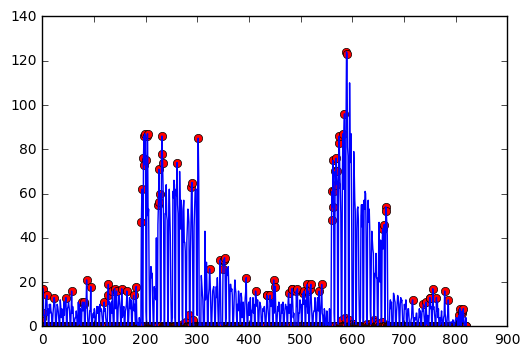

In [61]:
plt.plot(data2_ndfl_plot_x,data2_ndfl_plot_y,'ro',data_ndfl_plot_x,data_ndfl_plot_y,'b-')
plt.show()

Найдем 100 запросов с самой большой важностью и запишем в файл:
В файле можно увидеть запросы формата "00000000..", которые скорее всего являются выбросами, поскольку, проанализировав их появление, я увидел, что их частота 1-2 раза за весь период сильно возрастает.(Проблему можно было решить логарифмированием, как я уже писал выше) 

In [ ]:
c3.execute("select distinct z.q,z.power,p.day from (SELECT q,max(strength) as power FROM timeline3 group by q order by power desc LIMIT 100)as z join timeline3 as p on z.q=p.q and z.power=p.strength order by power desc")
row=c3.fetchall()
with open("task2.1_output.txt", "w") as text_file:
     for k in row:
        print("{0} {1} {2}".format(k[0].strip('" '),k[1],k[2]),file=text_file)

# Задание 2

Разберем наш пример на предмет сезонности

In [ ]:
c3.execute("SELECT * FROM timeline3 where q='форма 3-НДФЛ' order by day ")
data2=c3.fetchall()

In [139]:
dates = pd.date_range('06/01/2000', periods=822,freq='D')
seas_data=pd.DataFrame(data_ndfl_plot_y,index=dates)

In [145]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

Выполнив сезонную декомпозицию и применив уже использованный ранее метод "окна", можно увидеть наличие годовой сезонности с апреля, что очень логично, поскольку налоговую декларацию подают до 30 апреля ежегодно.
Из этого можно сделать вывод, что скорее всего конец периода активности приходится на конец апреля-начало мая.
Далее я буду пользоваться именно этой эвристикой

(-1.5, 1.5)

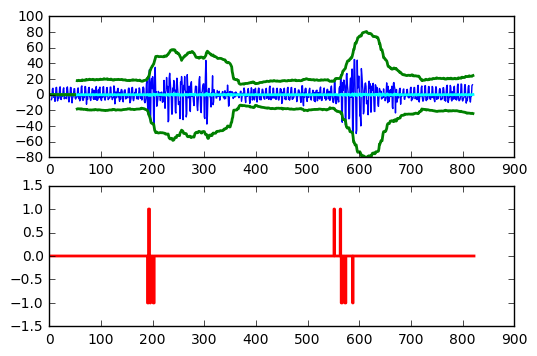

In [227]:
y=sm.tsa.seasonal_decompose(seas_data).resid.values
# y=data_ndfl_plot_y
lag = 50
threshold = 3
influence = 1
result=thresholding_algo(y,lag,threshold,influence)
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)

Для массовой проверки наличия сезонности можно использовать два 2 непараметрических теста на наличие стабильной сезонности:

__Тест Фридмана__

In [241]:
print ("P-value = %r:" % stats.friedmanchisquare(data_ndfl_plot_y[:182],data_ndfl_plot_y[183:365],data_ndfl_plot_y[366:548],data_ndfl_plot_y[549:731]).pvalue)

P-value = 1.7595058303285852e-15:


__Тест Краскелла Уоллиса__

In [239]:
print ("P-value = %r:" % stats.kruskal(data_ndfl_plot_y[:182],data_ndfl_plot_y[183:365],data_ndfl_plot_y[366:548],data_ndfl_plot_y[549:731]).pvalue)

P-value = 9.3633862829505654e-15:


На данном примере видно, что обе нулевые гипотезы об отсутсвии стабильной сезонности отвергаются при большом уровне значимости, следовательно сезонность есть!

Для выходного файла будем считать тест на уровне значимости 5%.

P.S. К сожалению, алгоритм выполняется довольно долго и за 5 часов он успел заполнить текстовый файл всего на 500кб.

In [402]:
c2.execute("SELECT * FROM timeline")
row=c2.fetchone()
name=row[0]
unique_data=[]
data_ndfl_plot_y=[]
counter=0
index_rows=0
with open("task2.2_output.txt", "w") as text_file:
    while (True):
        while (row is not None and name==row[0]):
#             print('kek' +row[0])
            unique_data.append(row)
            row=c2.fetchone()
            index_rows+=1
        if (row is None):
            break
        index=0
        for k in unique_data:
            data_ndfl_plot_y=np.append(data_ndfl_plot_y,k[1])
#             print ('kek2',k[0],k[1],k[2],index)
            data_ndfl_plot_y=np.insert(data_ndfl_plot_y,index,np.zeros(shape=(1,(k[2]-index)))[0])
            index=k[2]+1
        data_ndfl_plot_y=np.append(data_ndfl_plot_y,np.zeros(shape=(1,822-len(data_ndfl_plot_y)))[0])
        if (stats.friedmanchisquare(data_ndfl_plot_y[:182],data_ndfl_plot_y[183:365],data_ndfl_plot_y[366:548],data_ndfl_plot_y[549:731]).pvalue< 0.05 and stats.kruskal(data_ndfl_plot_y[:182],data_ndfl_plot_y[183:365],data_ndfl_plot_y[366:548],data_ndfl_plot_y[549:731]).pvalue <0.05 ):
#             print (name)
            text_file.write("{}\n".format(name.encode('utf-8').strip('" ')))
#         print (data_ndfl_plot_y)
        data_ndfl_plot_y=[]
        name=row[0]
        del unique_data[:]

KeyboardInterrupt: 

# Задание 3

На выбранном примере попробуем построить прогно, используя сезонную ARIMA (SARIMAX):

In [404]:
c2.execute("SELECT * FROM timeline where q='форма 3-НДФЛ' order by day ")
data=c2.fetchall()

In [405]:
data_ndfl_plot_y=[]
index=0
for k in data:
    data_ndfl_plot_y=np.append(data_ndfl_plot_y,k[1])
    data_ndfl_plot_y=np.insert(data_ndfl_plot_y,index,np.zeros(shape=(1,(k[2]-index)))[0])
    index=k[2]+1
data_ndfl_plot_y=np.append(data_ndfl_plot_y,np.zeros(shape=(1,822-len(data_ndfl_plot_y)))[0])

In [406]:
dates = pd.date_range('06/01/2000', periods=822,freq='D')
seas_data=pd.DataFrame(data_ndfl_plot_y,index=dates)

Тест Дики-Фулера говорит нам о том, что нельяз отвергнуть гипотезу о нестационарности ряда. Попробуем сделать прогноз по текущему нестационарном ряду. К счастью, как выяснится дальше, транформация Бокса-Кокса и "шифтинг" нам не понадобятся. 

Критерий Дики-Фуллера: p=0.118536


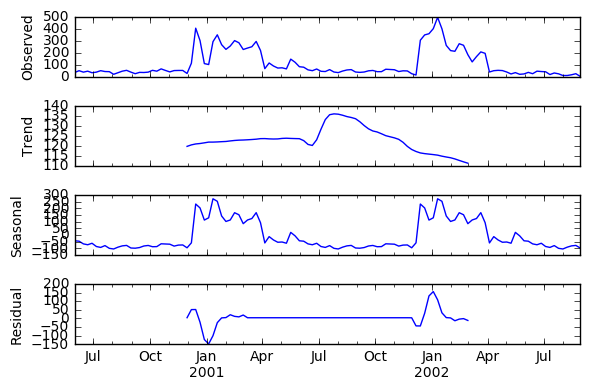

In [407]:
sm.tsa.seasonal_decompose(seas_data.resample('7D').sum()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(seas_data.resample('7D').sum()[0])[1])

Для подбора степеней AR и MA построим ACF и PACF:

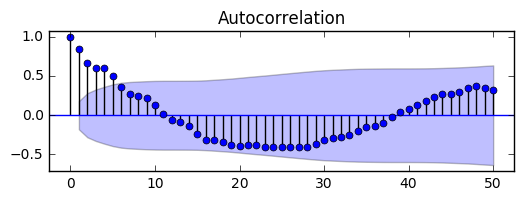

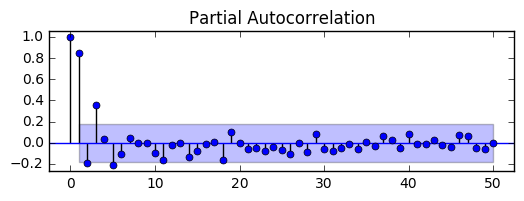

In [433]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(seas_data.resample('7D').sum().values[:,0], ax=ax,lags=50)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(seas_data.resample('7D').sum().values[:,0], ax=ax,lags=50)
plt.show()

Начальные приближения: Q=1, q=6, P=1, p=6

In [410]:
ps = range(0, 7)
d=1
qs = range(0, 7)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

Подберем лучшую модель на основе критерий Акайке

In [411]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(seas_data.resample('7D').sum(), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 5, 0, 0))
('wrong parameters:', (2, 5, 0, 1))
('wrong parameters:', (2, 5, 1, 0))
('wrong parameters:', (2, 5, 1, 1))
('wrong parameters:', (3, 5, 0, 0))
('wrong parameters:', (3, 5, 0, 1))
('wrong parameters:', (3, 5, 1, 0))
('wrong parameters:', (3, 5, 1, 1))
('wrong parameters:', (4, 3, 0, 0))
('wrong parameters:', (4, 3, 0, 1))
('wrong parameters:', (4, 3, 1, 0))
('wrong parameters:', (4, 3, 1, 1))
('wrong parameters:', (4, 5, 0, 0))
('wrong parameters:', (4, 5, 0, 1))
('wrong parameters:', (4, 5, 1, 0))
('wrong parameters:', (4, 5, 1, 1))
('wrong parameters:', (5, 5, 0, 0))
('wrong parameters:', (5, 5, 0, 1))
('wrong parameters:', (5, 5, 1, 0))
('wrong parameters:', (5, 5, 1, 1))
('wrong parameters:', (6, 3, 0, 0))
('wrong parameters:', (6, 3, 0, 1))
('wrong parameters:', (6, 3, 1, 0))
('wrong parameters:', (6, 3, 1, 1))
('wrong parameters:', (6, 4, 0, 0))
('wrong parameters:', (6, 4, 0, 1))
('wrong parameters:', (6, 4,

In [412]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
56   (2, 0, 0, 1)  1171.271528
72   (2, 4, 0, 1)  1171.602927
88   (3, 2, 0, 1)  1172.164869
104  (4, 0, 0, 1)  1172.248825
64   (2, 2, 0, 1)  1172.712423


In [413]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  0   No. Observations:                  118
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -581.636
Date:                            Sat, 22 Apr 2017   AIC                           1171.272
Time:                                    02:53:53   BIC                           1182.354
Sample:                                06-01-2000   HQIC                          1175.771
                                     - 08-29-2002                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1721      0.083      2.086      0.037       0.010       0.334
ar.L2         -0.4354      0.063   

Строим предсказание для нашего примера на 4 недели вперед

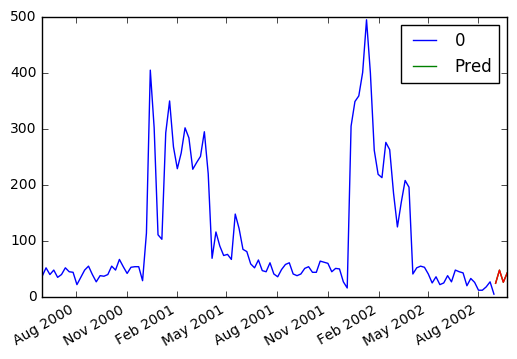

In [434]:
bc=seas_data.resample('7D').sum()
date_index = dates = pd.date_range('08/29/2002', periods=4,freq='W')
future = pd.DataFrame(index=date_index, columns= ['Pred'],data=best_model.predict(start=14,end=17).values)
bc=pd.concat([bc,future])
bc.plot()
bc.Pred.plot(color='r',label='Pred')
plt.show()

P.S. В данном задании я успел составить прогноз лишь к данному примеру. В остальных подход был бы аналогичен.